# Regression Modelling

Here we treat 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [3]:
# Load data
df = pd.read_csv("../data/preprocessed/Building_5.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [4]:
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

0.997


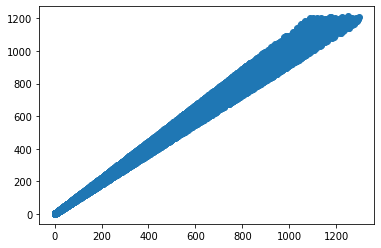

In [5]:
plt.scatter(x=df['pred_24h_direct_solar_W_m2_shift'], y=df['direct_solar_W_m2'])
print(df['pred_24h_direct_solar_W_m2_shift'].corr(df['direct_solar_W_m2']).round(3))

In [6]:
df.columns

Index(['month', 'hour', 'daylight_savings', 'indoor_temp',
       'avg_unmet_cooling_temp', 'indoor_hum', 'equipment_electric_power_kWh',
       'dhw_heating_kWh', 'cooling_load_kWh', 'solar_generation_W_kW',
       'outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2',
       'direct_solar_W_m2', 'pred_6h_outdoor_temp', 'pred_12h_outdoor_temp',
       'pred_24h_outdoor_temp', 'pred_6h_outdoor_hum', 'pred_12h_outdoor_hum',
       'pred_24h_outdoor_hum', 'pred_6h_diffuse_solar_W_m2',
       'pred_12h_diffuse_solar_W_m2', 'pred_24h_diffuse_solar_W_m2',
       'pred_6h_direct_solar_W_m2', 'pred_12h_direct_solar_W_m2',
       'pred_24h_direct_solar_W_m2', 'holiday', 'workday',
       'solar_generation_kW', 'total_load_kWh', 'net_load_kWh',
       'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift',
       'pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift'],
      dtype='object')

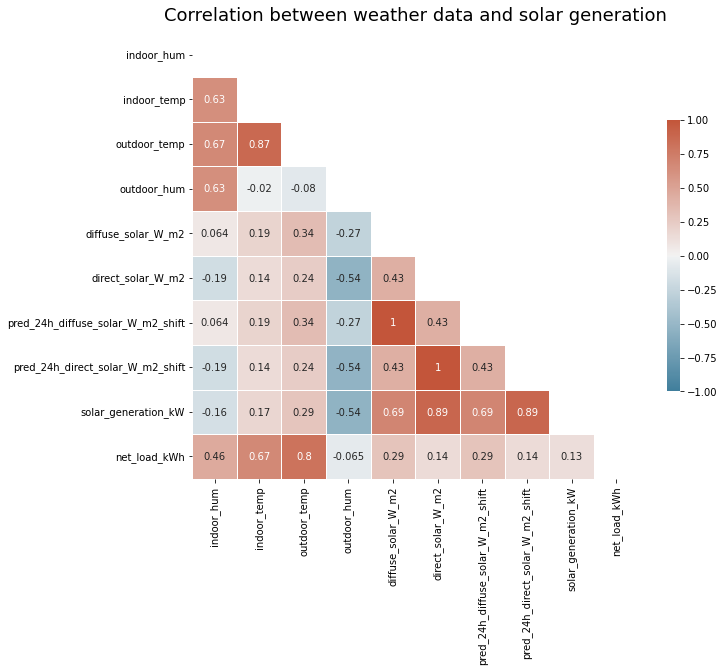

In [7]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
corr_weather= df[['indoor_hum','indoor_temp','outdoor_temp','outdoor_hum', 'diffuse_solar_W_m2', 
                    'direct_solar_W_m2', 'pred_24h_diffuse_solar_W_m2_shift', 
                    'pred_24h_direct_solar_W_m2_shift', 'solar_generation_kW','net_load_kWh']].corr()
mask = np.triu(np.ones_like(corr_weather, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr_weather, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
heatmap.set_title('Correlation between weather data and solar generation', fontdict={'fontsize':18}, pad=12);


### Simple linear regression model using measured weather conditions to predict net energy usage

In [19]:
X = df[['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 'hour', 'month']]
y = df['net_load_kWh']

X = pd.get_dummies(X, drop_first=True)

# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Calculate r-squared 
y_pred = lin_reg.predict(X)
print("R-squared:", r2_score(y, y_pred).round(3))

coef = lin_reg.coef_
intercept = lin_reg.intercept_

df['net_load_kWh_forecast'] = y_pred

R-squared: 0.688


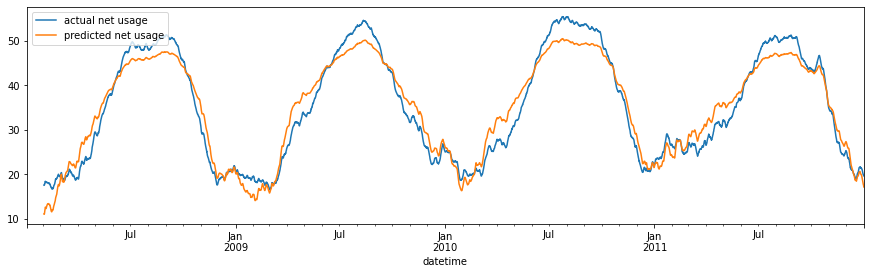

In [24]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kWh'].rolling(24*30).mean().plot(label="actual net usage")
df['net_load_kWh_forecast'].rolling(24*30).mean().plot(label="predicted net usage")
plt.legend(loc='upper left')

### Linear regression model with 5 polynomial features to predict net energy usage

In [25]:
rsquared = {"n":[], "rsquared": []}
n = 5
poly = PolynomialFeatures(degree=n, include_bias=False)
poly_features = poly.fit_transform(X)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)
y_pred = poly_reg_model.predict(poly_features)
print("n:", n," R-squared:", r2_score(y, y_pred).round(3))
rsquared["n"].append(n)
rsquared["rsquared"].append(r2_score(y, y_pred).round(3))

coef = poly_reg_model.coef_
intercept = poly_reg_model.intercept_

df['net_load_kWh_forecast'] = y_pred

n: 5  R-squared: 0.897


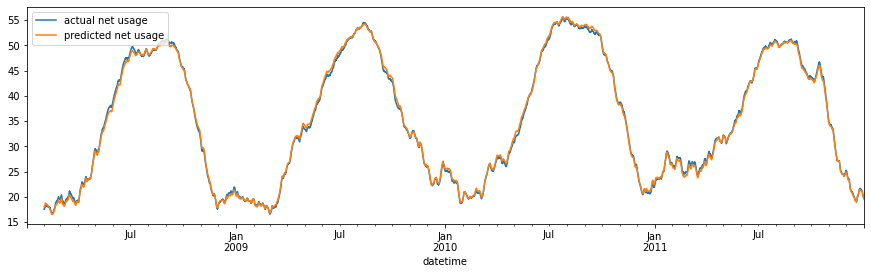

In [26]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kWh'].rolling(24*30).mean().plot(label="actual net usage")
df['net_load_kWh_forecast'].rolling(24*30).mean().plot(label="predicted net usage")
plt.legend(loc='upper left')

### Using 24hr weather predictions to calculate net energy usage

In [11]:
X_forecast = df[['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 'hour', 'month']]
y_forecast = df['net_load_kWh']

X_forecast = pd.get_dummies(X_forecast, drop_first=True)

poly_features = poly.fit_transform(X_forecast)
y_pred = poly_reg_model.predict(poly_features)

# Calculate r-squared 
print("R-squared:", r2_score(y_forecast, y_pred).round(3))

df['net_load_kWh_forecast'] = y_pred

R-squared: 0.888


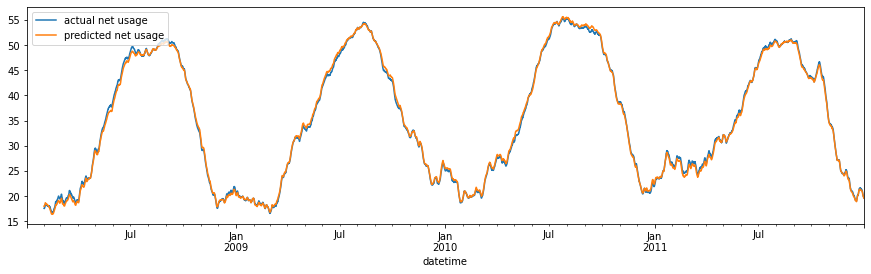

In [12]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kWh'].rolling(24*30).mean().plot(label="actual net usage")
df['net_load_kWh_forecast'].rolling(24*30).mean().plot(label="predicted net usage")
plt.legend(loc='upper left')

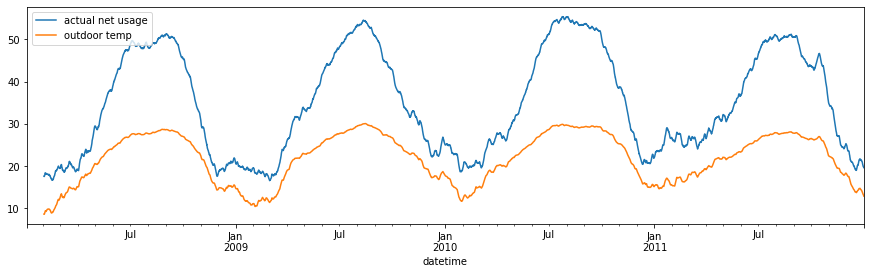

In [13]:
fig, ax = plt.subplots(figsize=(15,4))
df['net_load_kWh'].rolling(24*30).mean().plot(label="actual net usage")
df['outdoor_temp'].rolling(24*30).mean().plot(label="outdoor temp")
plt.legend(loc='upper left')

<AxesSubplot:xlabel='outdoor_temp', ylabel='net_load_kWh'>

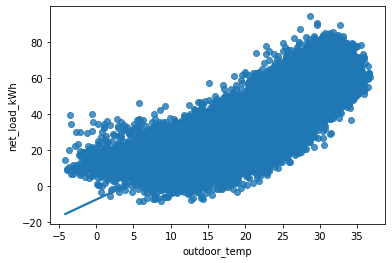

In [14]:
sns.regplot(x="outdoor_temp", y="net_load_kWh", data=df, ci=None)

In [15]:
df_new = df[['net_load_kWh','outdoor_temp']]
df_new['net_load_kWh_pctchg'] = df['net_load_kWh'].pct_change()
df_new['outdoor_temp_pctchg'] = df['outdoor_temp'].pct_change()
df_new = sm.add_constant(df_new)
df_new = df_new.dropna()

In [16]:
results = sm.OLS(df_new['outdoor_temp'],df_new[['const','net_load_kWh']]).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           outdoor_temp   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 6.441e+04
Date:                Mon, 18 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:42:46   Log-Likelihood:            -1.0078e+05
No. Observations:               35009   AIC:                         2.016e+05
Df Residuals:                   35007   BIC:                         2.016e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.1131      0.051    198.096   

In [17]:
df_new['net_load_kWh_pctchg'].autocorr()

0.0004985600839615301

In [18]:
df_new['net_load_kWh'].diff().autocorr()

-0.17648638134659833